In [ ]:
from sklearn import datasets
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Loading The Data


In [ ]:
# load raw train data
!gdown 1EGHpyOZL8RnOPnz8WY-OGDMi-rSBC8I5
df = pd.read_csv('/content/breast cancer.csv')
df.head()

Downloading...
From: https://drive.google.com/uc?id=1EGHpyOZL8RnOPnz8WY-OGDMi-rSBC8I5
To: /content/breast cancer.csv
100% 125k/125k [00:00<00:00, 119MB/s]


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


در صورت وجود داده از ست رفته آن را باید حذف کنیم.

In [ ]:
# checking for missing values
print(df.isna().any())

id                         False
diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_w

برای راحتتر کردن بررسی ستون‌ها را به حالت عمودی تبدیل میکنیم. زیرا تعداد ستون‌ها زیاد است.
و همچنین از دستور دیسکرایب برای تحلیل آماری استفاده میکنیم.



In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.106000,0.161900,0.179200,1.957000e-01,3.040000e-01


دیتاها را به دو حالت بدخیم و خوش خیم تقسیم میکنیم و به خوش خیم‌ها 1 و به بدخیم‌ها 0 نسبت میدهیم.

In [ ]:
df['diagnosis'] = df['diagnosis'].replace({'M': 1, 'B': 0})

چک میکنیم که در دیتاها، دیتای دابلیکیت و تکراری وجود دارد یا خیر. اگر بود آن را حذف میکنیم.

In [ ]:
print(df[df.duplicated()])

Empty DataFrame
Columns: [id, diagnosis, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst, Unnamed: 32]
Index: []


unnamed , id
حذف میشوند چون ارزش اطلاعاتی زیادی ندارند.

In [ ]:
df.drop(['Unnamed: 32','id'], axis = 1,inplace=True)

تارگت را تعیین میکنیم و آنها را رسم میکنیم تا توازن آنها را ببینیم.

<Axes: xlabel='diagnosis', ylabel='count'>

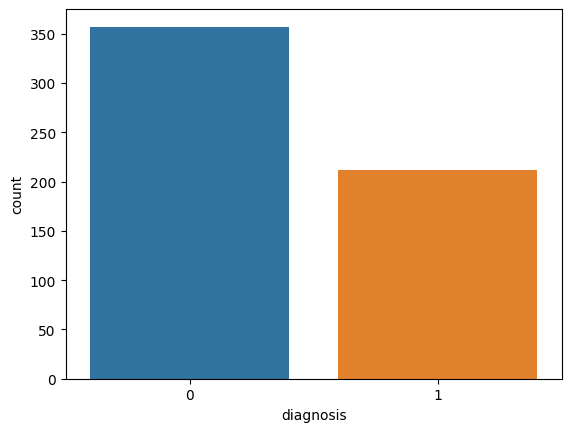

In [ ]:
# target distribution
sns.countplot(x=df['diagnosis'])

مارتیس کورلیشن را رسم میکنیم تا بتوانیم بفهمیم کدامین از دیتاها بیشتر از همه باهم همبستگی دارند و روی هم تاثیر میگذارند.

<Axes: >

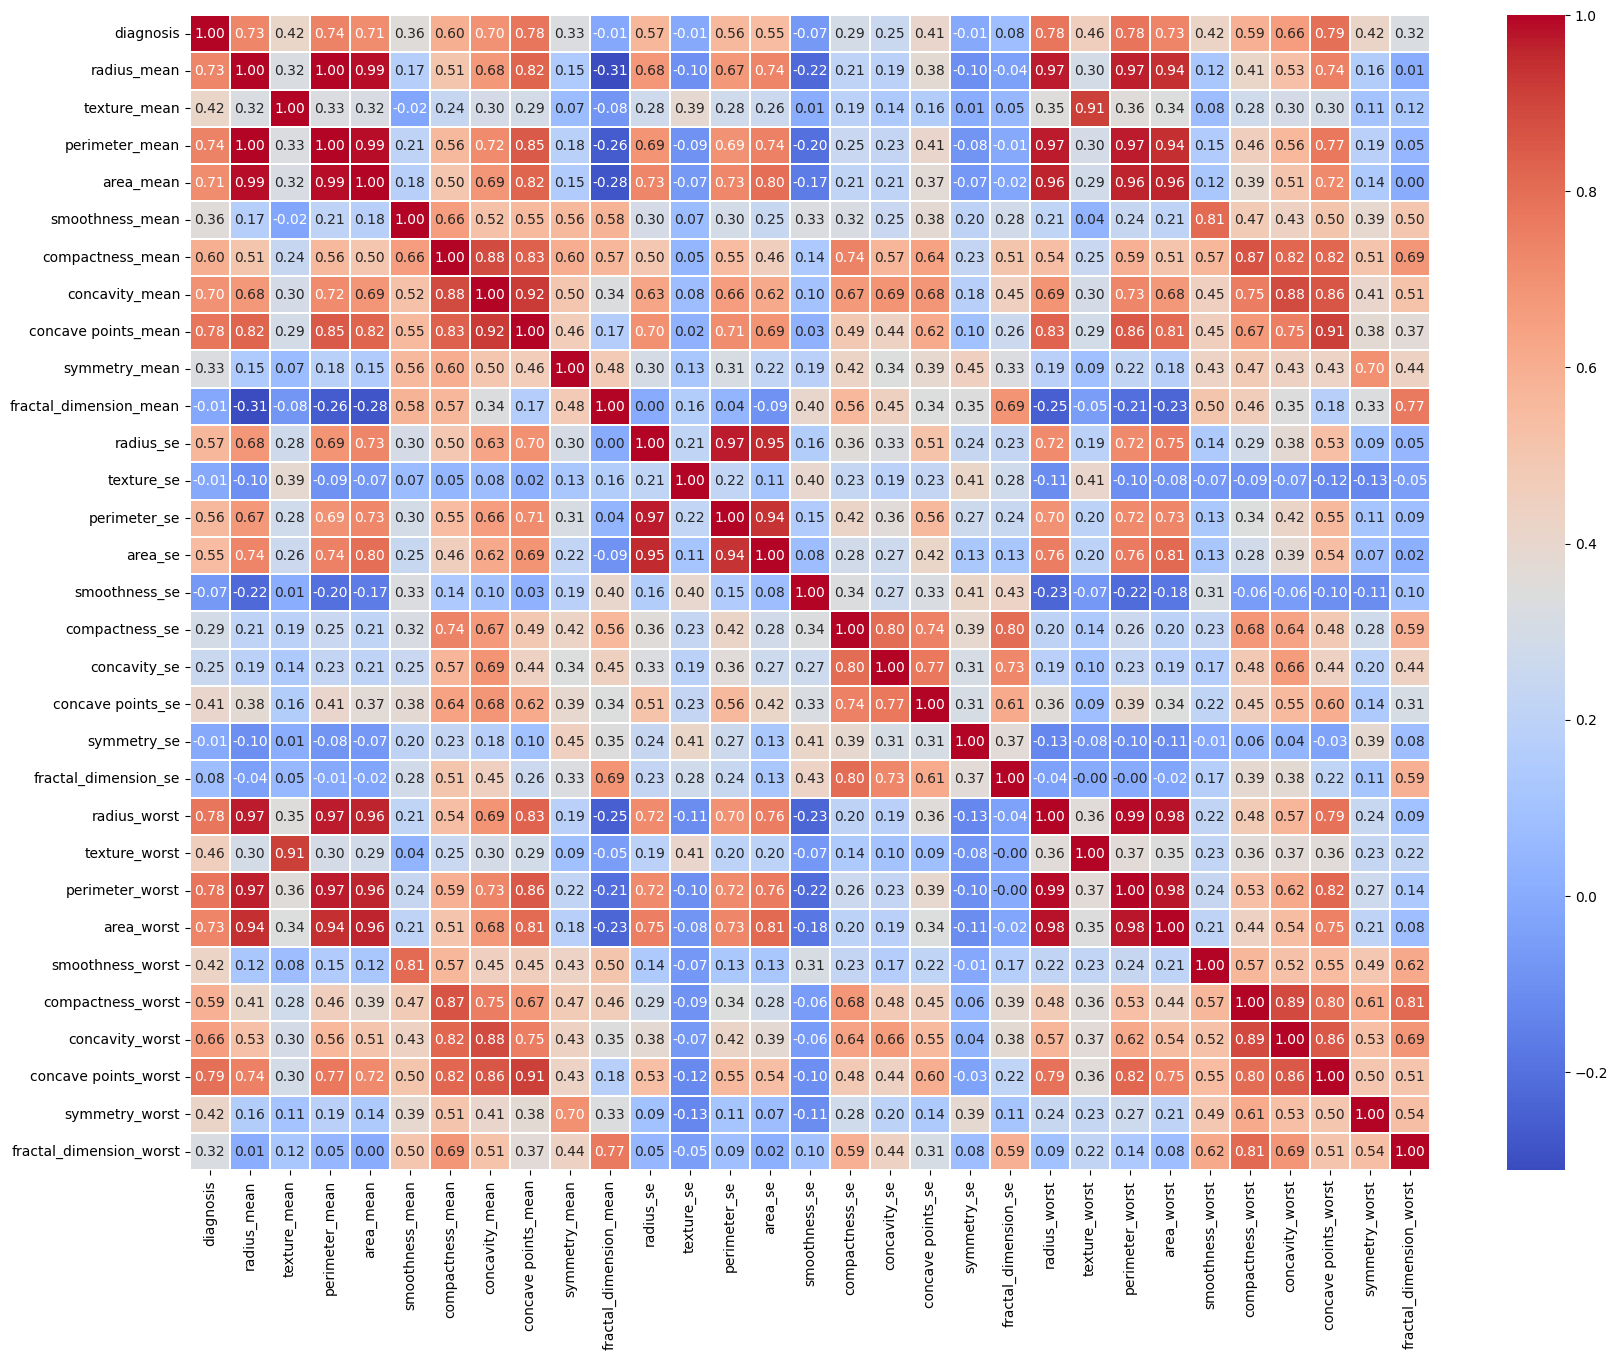

In [ ]:
# correlation matrix
fig = plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=format('.2f'), linewidths=0.003)

# Feature Selection with 0.90 Threshold

در اینجا دیتاهایی که بالای 90 درصد همبستگی دارند را رسم میکند. در سمت راست
پایین سه داده داریم که با 0.99 , 0.98 , 0.98 همبستگی دارند و از طریق همدیگر به دست می آیند. پس دوتای آنها را حذف و یکی از آنها را نگه میداریم.

Text(0.5, 1.0, 'Highly Correlated Features')

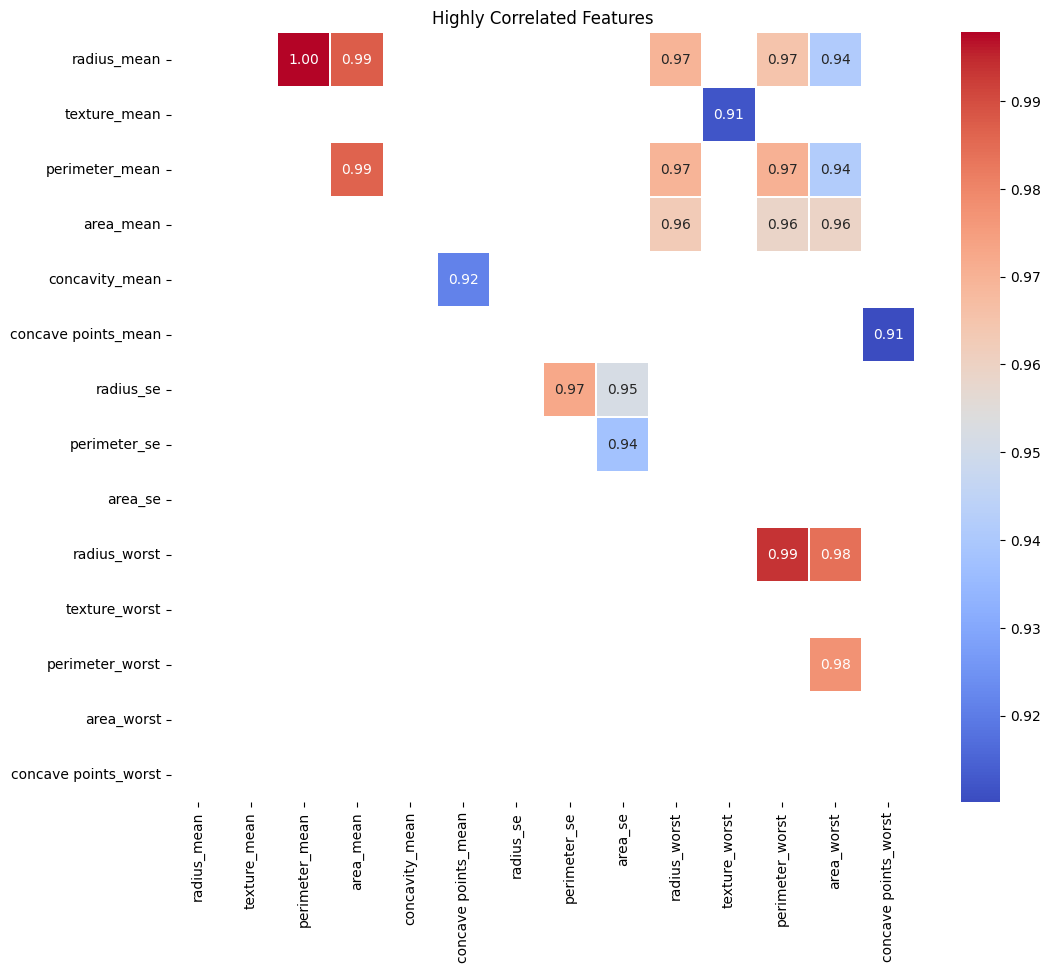

In [ ]:
# remove highly correlated features
correlation_mat = df.corr()
for row in correlation_mat.index:
    for col in correlation_mat.columns:
        if row==col or correlation_mat.loc[row,col].round(2)<0.90:
            correlation_mat.loc[row,col] = np.nan
fig = plt.figure(figsize=(12,10))
highly_correlated = correlation_mat.dropna(how='all').dropna(axis=1,how='all')
mask = np.tril(np.ones_like(highly_correlated))
sns.heatmap(highly_correlated, cmap='coolwarm', mask=mask,annot=True, fmt=format('.2f'), linewidths=0.003)
plt.title('Highly Correlated Features')

دوباره نمودار را میکشیم و میبینیم که مشکل دیتاهایی که همبستگی زیادی داشتند برطرف شدند.

Text(0.5, 1.0, 'Modified Correlation')

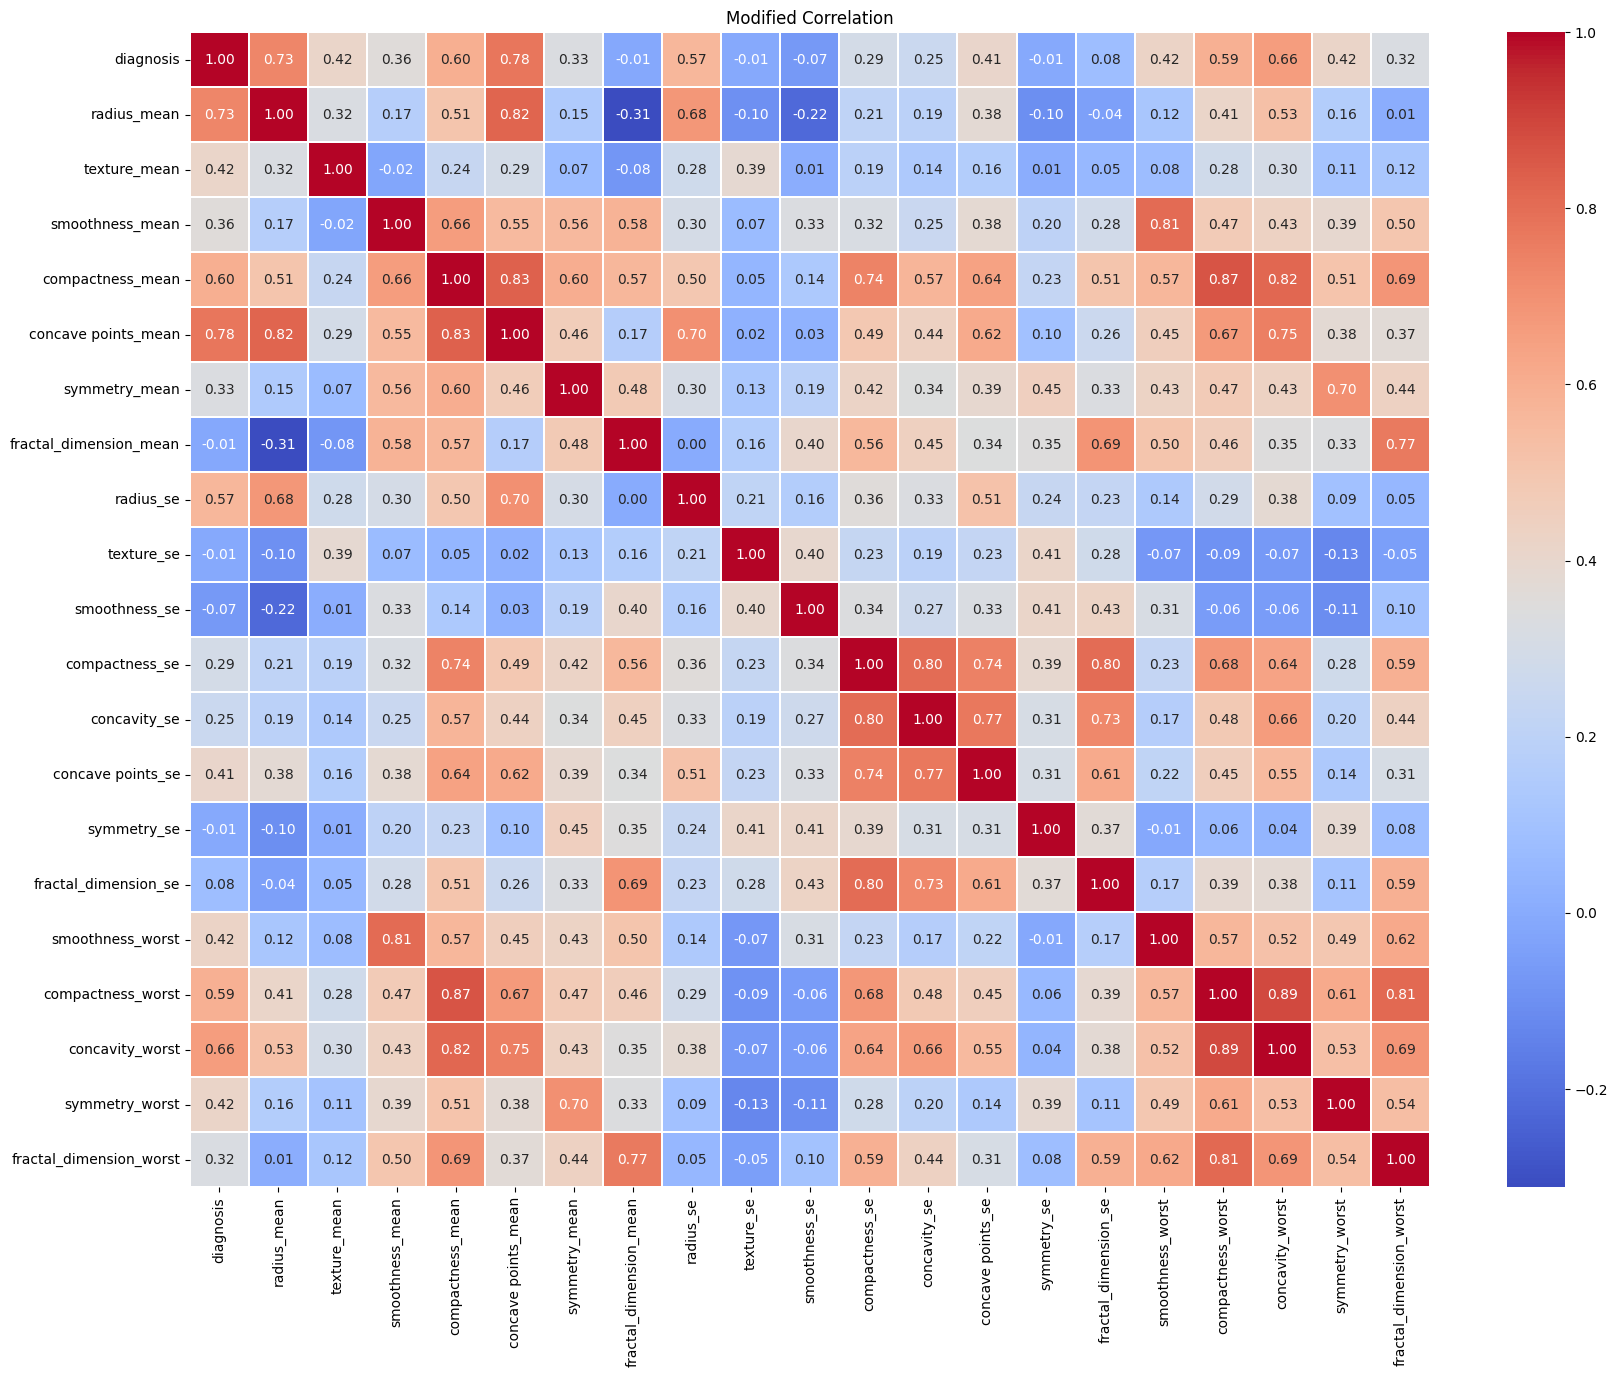

In [ ]:
# Manual Feature Extraction Results

df_1 = df.drop(columns=['perimeter_mean', 'area_mean', 'perimeter_se', 'perimeter_worst', 'area_worst','radius_worst', 'texture_worst', 'area_se', 'concave points_worst', 'concavity_mean'])
correlation_mat = df_1.corr()
fig = plt.figure(figsize=(20,15))
sns.heatmap(correlation_mat, cmap='coolwarm',annot=True, fmt=format('.2f'), linewidths=0.003)
plt.title('Modified Correlation')

همبستگی دیتاها را با ویژگی هدف بررسی میکنیم که ببینیم چقدر بقیه ویژگی‌ها روی آن تاثیر میگذراند. میبینیم که همه آنها تاثیر مستقیمی دارند.

<Axes: >

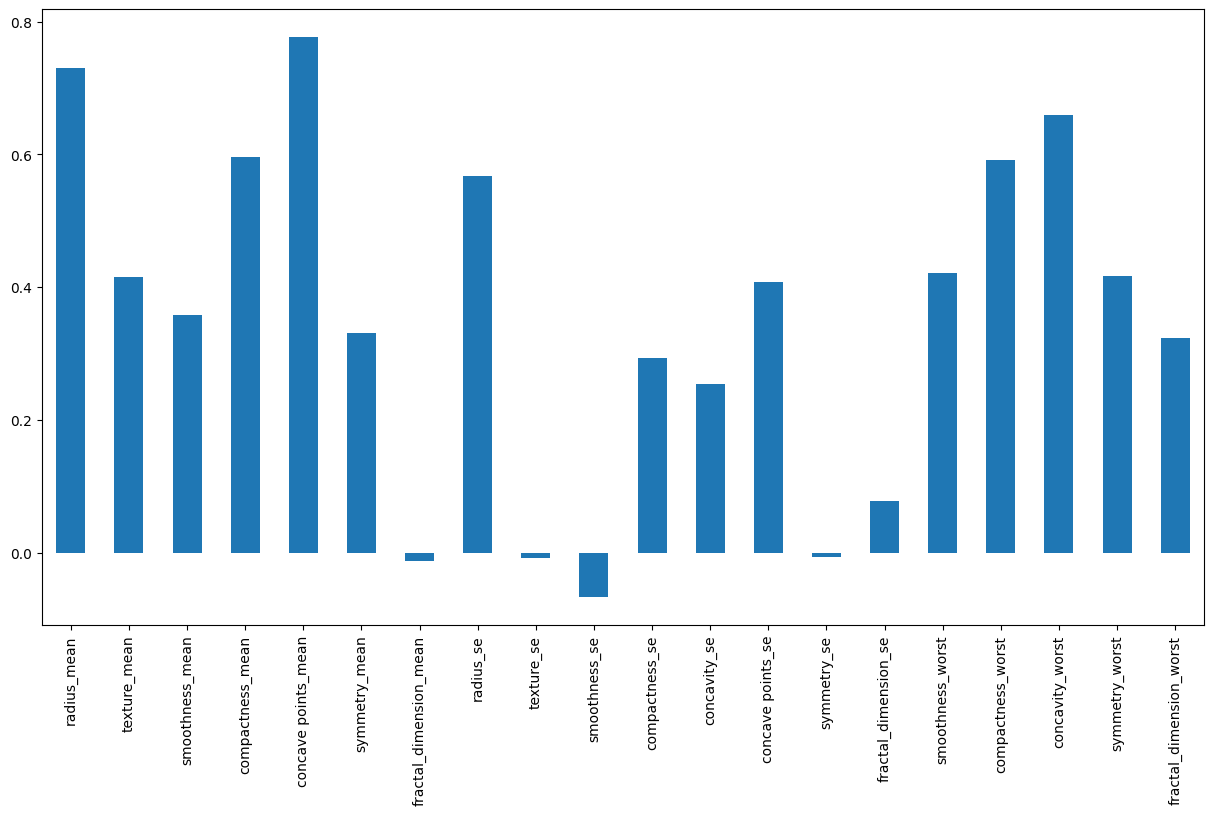

In [ ]:
# correlation of features with target
target_corr = correlation_mat['diagnosis'].drop(['diagnosis'])
target_corr.plot(kind='bar', figsize=(15,8))

نمودار kde
این نمودار یک نمایش توزیع احتمالی است و درواقع تابع تراکمی احتمال است.
 احتمال تراکم هر ویژگی‌ای را بازگو میکند و نشان میدهد.

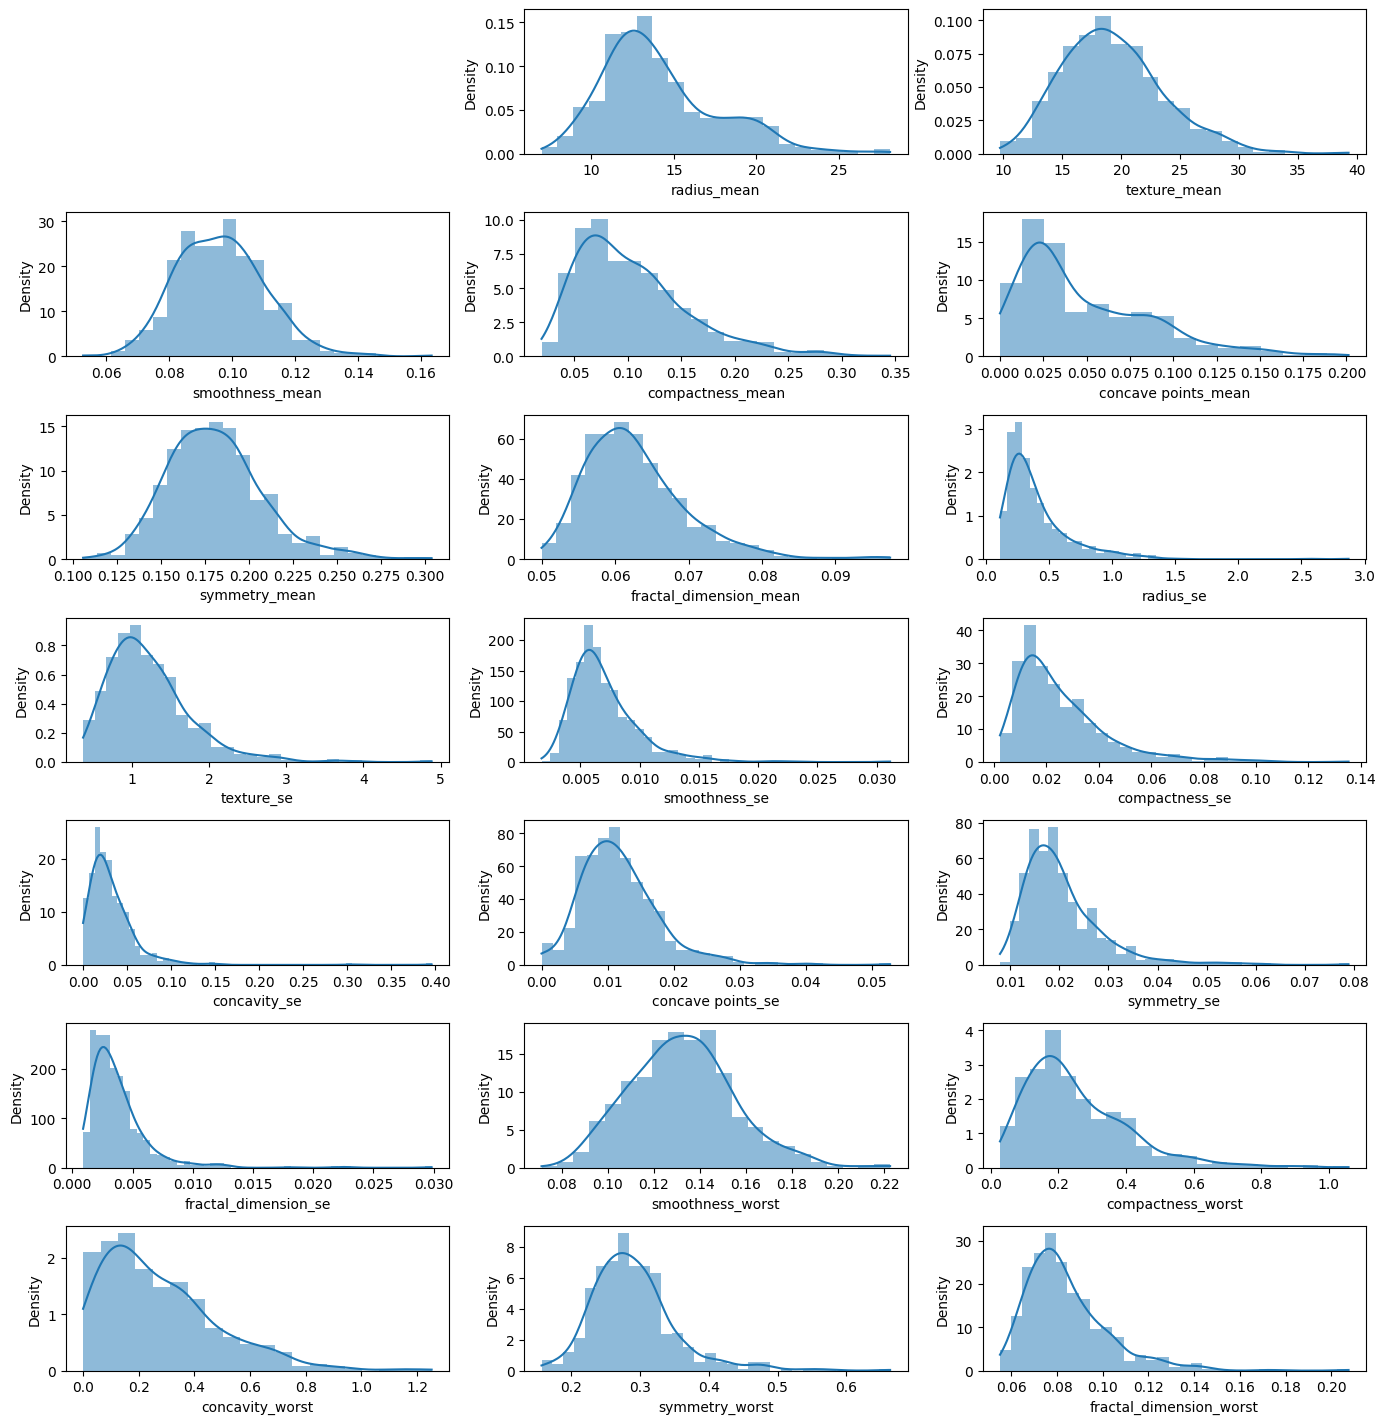

In [ ]:
# kde plot for features
plt.figure(figsize = (14, 20))
for i,c in enumerate(df_1.columns):
    if c != 'diagnosis':
        ax = plt.subplot(10, 3, i+1)
        sns.histplot(df_1[c], kde=True, stat='density', linewidth=0)
        plt.xlabel(c)

plt.tight_layout()
plt.show()

##Split


ستون هدف را دراپ میکنیم  و با نسبت سایز 0.2 بقیه ویژگی‌ها را تقسیم میکنیم.

بااستفاده از train_test_split

استیت رندوم هم عددی گذاشتیم که هرموقع از این برنامه استفاده کردیم جواب یکسانی به ما بدهد.

In [ ]:
from sklearn.model_selection import train_test_split

X = df_1.drop(columns=['diagnosis'])
Y = df_1['diagnosis']
x_train , x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

در اینجا دیتاها را استانداردسازی میکنیم با استفاده از استاندارد اسکالر.

بعد از استانداردسازی با استفاده از الگوریتم پی سی ای مولفه‌های اصلی را استخراج میکنیم. سپس داده ها را نرمال سازی میکنیم.

In [ ]:
# standardizing features
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA

# separating target from the rest

scaler = StandardScaler()
Fit_std = scaler.fit(x_train)
x_train_std = Fit_std.transform(x_train)
x_test_std = Fit_std.transform(x_test)

# # dimension reduction using pca
pca = PCA(n_components='mle')
Fit_pca = pca.fit(x_train_std)
x_train_pca = Fit_std.transform(x_train_std)
x_test_pca = Fit_std.transform(x_test_std)

norm = Normalizer()
Fit_nrm = norm.fit(x_train_pca)
x_train_pca= Fit_nrm.transform(x_train_pca)
x_test_pca= Fit_nrm.transform(x_test_pca)


pd.DataFrame(x_train_pca).describe().transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
0,455.0,-0.011028,0.005827,-0.050306,-0.013180,-0.009999,-0.007534,-0.001243
1,455.0,-0.012459,0.006528,-0.055268,-0.015156,-0.011162,-0.008434,-0.001380
2,455.0,-0.014519,0.177536,-0.482935,-0.140029,-0.021422,0.094923,0.661940
3,455.0,-0.007388,0.046307,-0.155360,-0.040305,-0.015814,0.016885,0.210949
4,455.0,-0.003499,0.071368,-0.210868,-0.049931,-0.023152,0.035546,0.426182
5,455.0,-0.019388,0.099418,-0.383192,-0.077846,-0.022861,0.033891,0.466809
6,455.0,-0.054606,0.290130,-0.713834,-0.279362,-0.091442,0.151938,0.808998
7,455.0,-0.004257,0.008866,-0.023396,-0.009256,-0.005989,-0.000810,0.052203
8,455.0,-0.006562,0.005808,-0.034442,-0.009858,-0.006660,-0.002820,0.015336
9,455.0,-0.109682,0.531263,-0.954835,-0.572799,-0.229836,0.316099,0.979109


در اینجا دوباره از نمودار ذکر شده استفاده میکنیم و میبینیم که توزیع ویژگی‌ها و داده‌ها بهتر و به نرمال نزدیک می‌شوند.

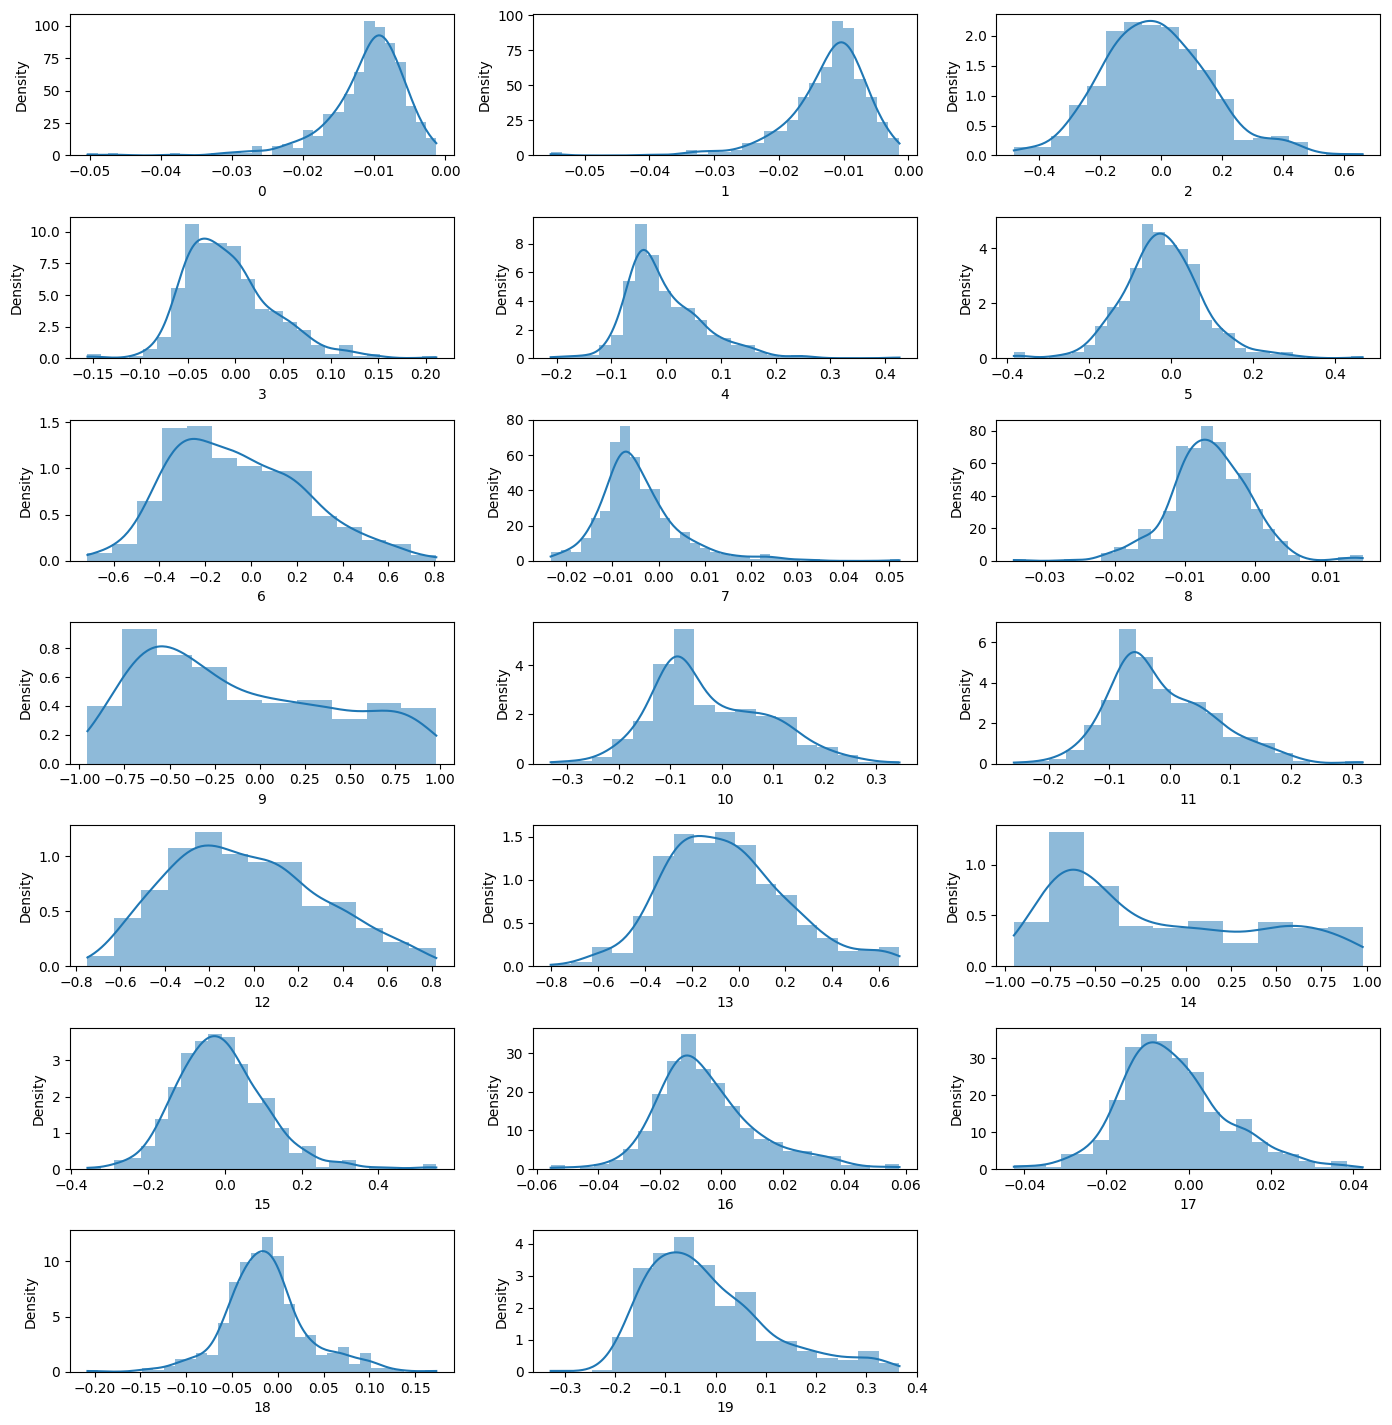

In [ ]:
# kde plot for features after standardization and normalization
x_train_pca_df = pd.DataFrame(x_train_pca)
plt.figure(figsize = (14, 20))
for i,c in enumerate(x_train_pca_df.columns):
    if c != 'diagnosis':
        ax = plt.subplot(10, 3, i+1)
        sns.histplot(x_train_pca_df[c], kde=True, stat='density', linewidth=0)
        plt.xlabel(c)

plt.tight_layout()
plt.show()

---

# Modeling

برای مدلسازی از کتابخانه تنسورفلو با رابط کراس استفاده میکنیم.
به دلیل اینکه ابعاد به 20 مولفه اصلی کاهش پیدا کرده است، لایه اول شبکه عصبی را با 20 نورون قرار دادیم با تابع فعال ساز ذکر شده، لایه دوم را با ۷ نورون و لایه سوم ۴ نورون ساخته شده است. سپس لایه خروجی دارای دو نورون با تابع فعالسازی سیگموید برای نمایش خروجی بصورت احتمالاتی ساخته شده است. دلیل انتخاب تعداد لایه های پنهان سعی و خطا و دلیل انتخاب تعداد نورون های هر لایه پنهان معیار میانگین هندسی تعداد نورون های لایه قبل و بعد آن است.

از اپتیمایزر های آدام و گرادیان کاهشی استوک استیک استفاده کرده ایم و آموزش مدل را به تابعی سپرده ایم که ورودی آن اپتیمایزر دلخواه، تعداد ایپاک ها و بچ سایز دلخواه است. سپس مدل های متعددی را ساخته و با استفاده از این تابع اموزش داده ایم. ابتدا تعیین لرنینگ ریت را به عهده خود اپتیمایزر قرار دادیم تا بتوانیم تاثیر ایپاک و بچ سایز را در خروجی مدل بسنجیم.

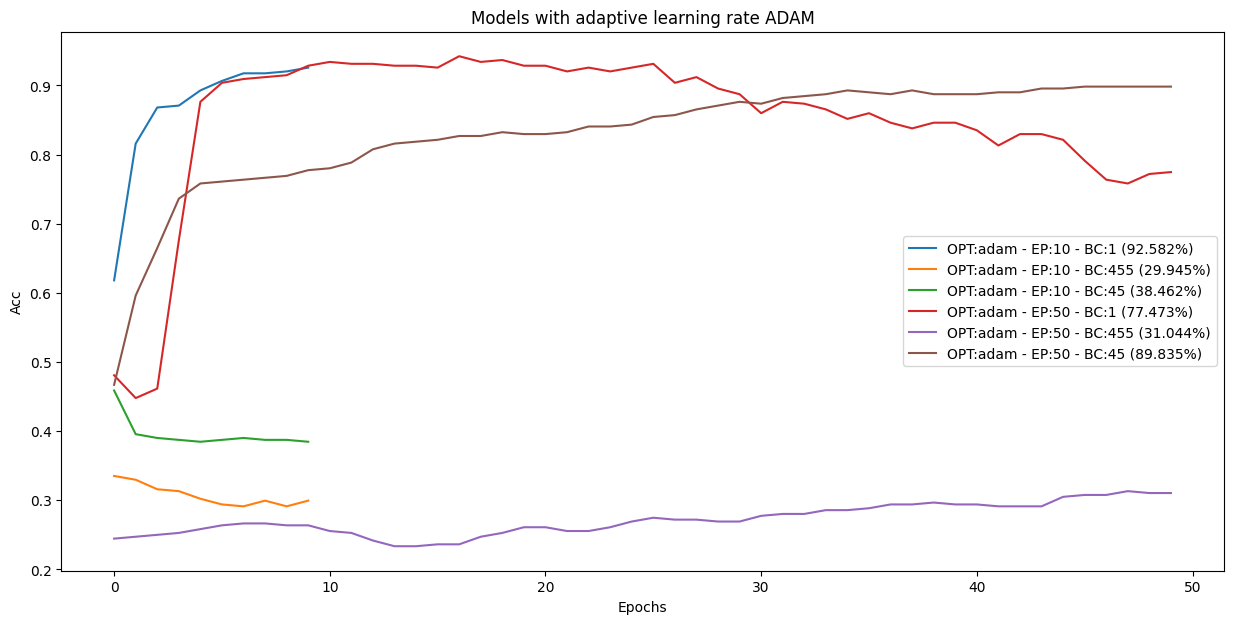

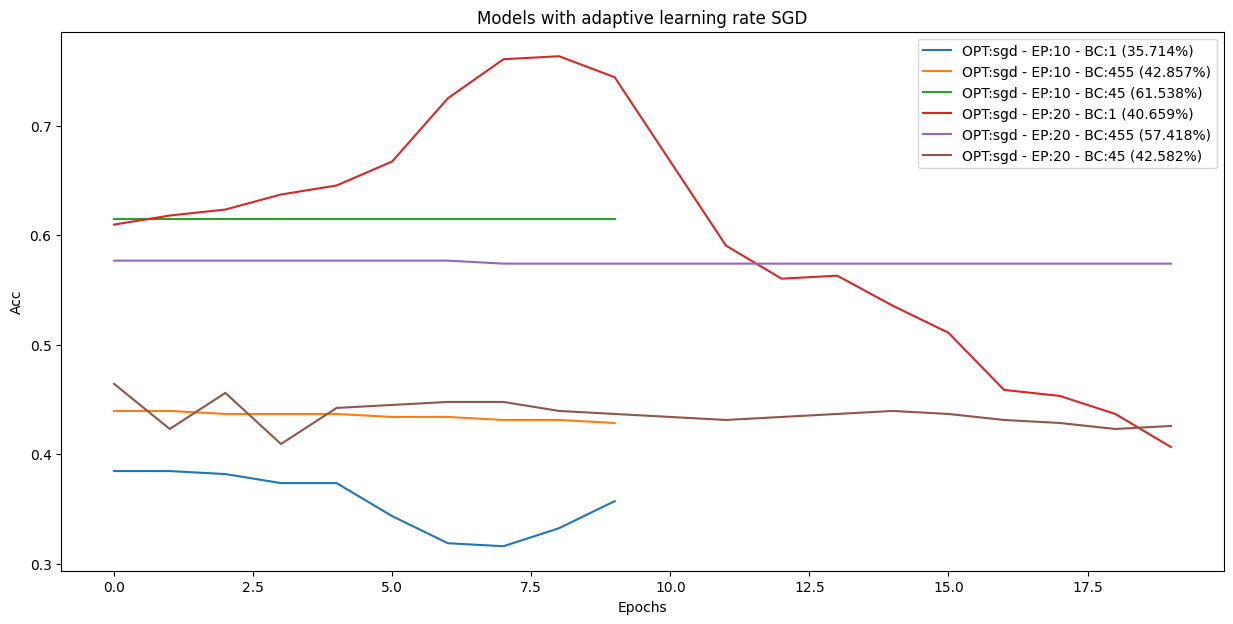

In [ ]:
import tensorflow as tf
tf.random.set_seed(3)
from keras.models import Sequential
from keras import layers,optimizers


def process_model(optimizer, epoch, batch_size, vb=0):
  model = Sequential([
                      layers.Dense(20),
                      layers.Dense(7, activation='relu'),
                      layers.Dense(4, activation='relu'),
                      layers.Dense(2, activation='sigmoid')
  ])
  if isinstance(optimizer, str):
    opt_label = optimizer
  else:
    opt_label  = str(optimizer.get_config()['name'])
    opt_label += '(' + str(optimizer.get_config()['learning_rate']) + ')'
  model.compile(optimizer=optimizer, loss=tf.keras.losses.mean_absolute_error, metrics=['accuracy'])
  history = model.fit(x_train_pca_df, y_train, epochs=epoch, batch_size=batch_size, validation_split = 0.2, verbose=vb)
  sns.lineplot(history.history['accuracy'], label=f'OPT:{opt_label} - EP:{epoch} - BC:{batch_size} ({history.history["accuracy"][-1]:.3%})')
  return model

models = []
# MODELS =======================================================================
fig = plt.figure(figsize=(15,7))
models.extend([
  process_model('adam', 10, 1),
  process_model('adam', 10, x_train_pca_df.shape[0]),
  process_model('adam', 10, x_train_pca_df.shape[0]//10),

  process_model('adam', 50, 1),
  process_model('adam', 50, x_train_pca_df.shape[0]),
  process_model('adam', 50, x_train_pca_df.shape[0]//10),
])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Models with adaptive learning rate ADAM')
fig.show()
# ==============================================================================
fig = plt.figure(figsize=(15,7))
models.extend([
  process_model('sgd', 10, 1),
  process_model('sgd', 10, x_train_pca_df.shape[0]),
  process_model('sgd', 10, x_train_pca_df.shape[0]//10),

  process_model('sgd', 20, 1),
  process_model('sgd', 20, x_train_pca_df.shape[0]),
  process_model('sgd', 20, x_train_pca_df.shape[0]//10),
])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Models with adaptive learning rate SGD')
fig.show()
# ==============================================================================

سپس با توجه به عملکرد هر مدل، از بین آنها بهترین ها را انتخاب کرده و تاثیر لرنینگ ریت را روی آنها میسنجیم. همانطور که مشخص است لرنینگ ریت وابسته به ایپاک و بچ سایز و همچنین خود اپتیمایزر مورد استفاده است. در این میان متوجه شدیم برای اپتیمایزر آدام لرنینگ ریت های کمتر و برای اپتیمایزر گرادیان کاهشی استوک استیک لرنینگ ریت بیشتر نتیجه بهتری میدهد. همچنین برای اپتیمایزر آدام ایپاک بالاتر و بچ سایز بیشتر عملکرد آن را بهبود میبخشد.

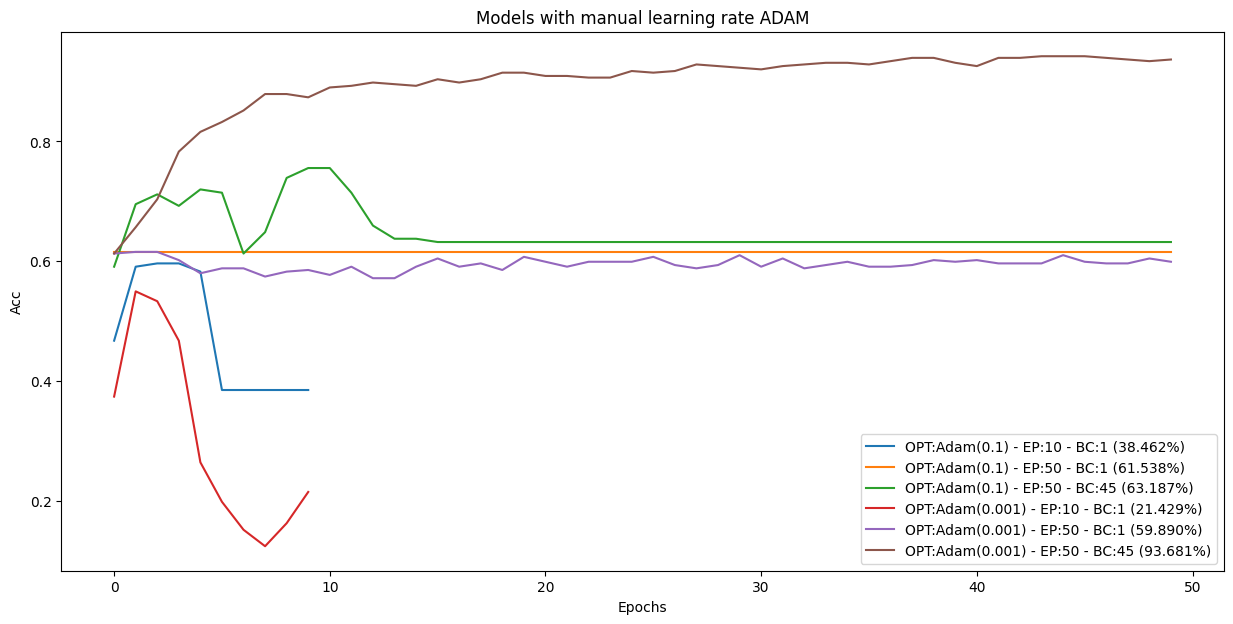

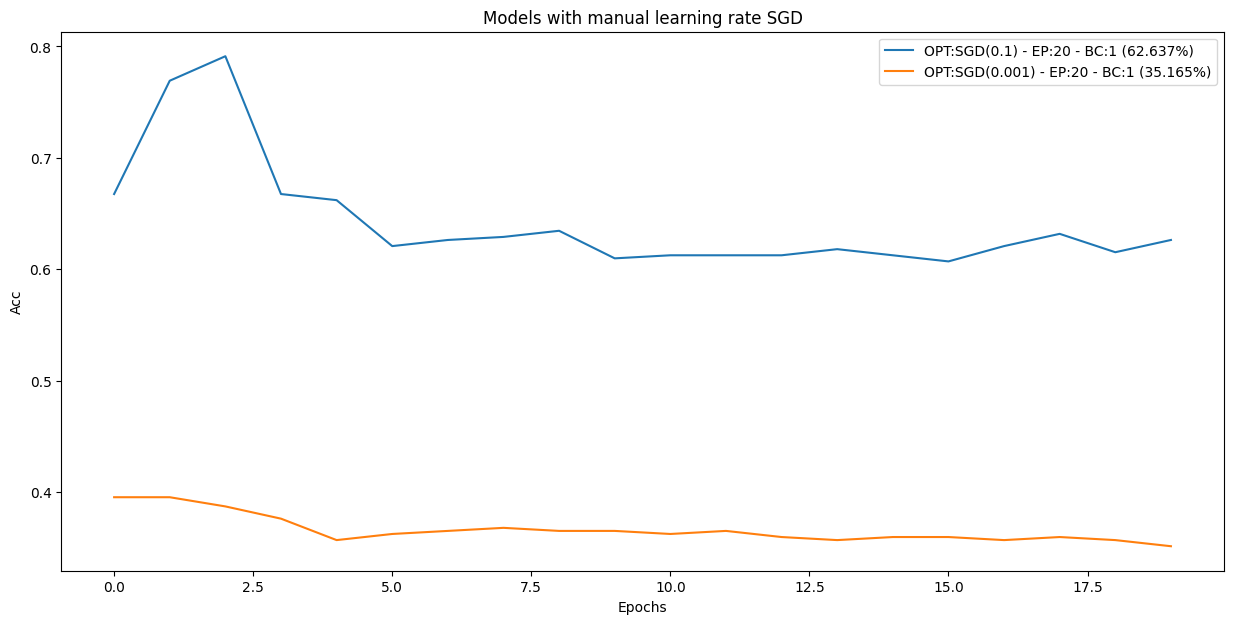

In [ ]:
fig = plt.figure(figsize=(15,7))
optimizer = optimizers.Adam(learning_rate=0.1)
models.extend([
  process_model(optimizer, 10, 1),
  process_model(optimizer, 50, 1),
  process_model(optimizer, 50, x_train_pca_df.shape[0]//10),
])
optimizer = optimizers.Adam(learning_rate=0.001)
models.extend([
  process_model(optimizer, 10, 1),
  process_model(optimizer, 50, 1),
  process_model(optimizer, 50, x_train_pca_df.shape[0]//10),
])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Models with manual learning rate ADAM')
fig.show()

fig = plt.figure(figsize=(15,7))
optimizer = optimizers.SGD(learning_rate=0.1)
models.extend([
  process_model(optimizer, 20, 1),
])
optimizer = optimizers.SGD(learning_rate=0.001)
models.extend([
  process_model(optimizer, 20, 1),
])

plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Models with manual learning rate SGD')
fig.show()

In [ ]:
# from keras import backend as K
# change learning rate
# K.set_value(model.optimizer.learning_rate, 0.001)
# print("Learning rate before second fit:", model.optimizer.learning_rate.numpy())
# history = model.fit(x_train_pca_df, y_train, epochs=100, batch_size=32, validation_split = 0.2)

#Evaluation

در انتها برای بهترین مدل اموزش داده شده ماتریس درهم ریختگی و معیار های ارزیابی پرسیژن و ریکال را محاسبه میکنیم.

Precision: 1.000000
Recall: 0.794872
F1 score: 0.885714


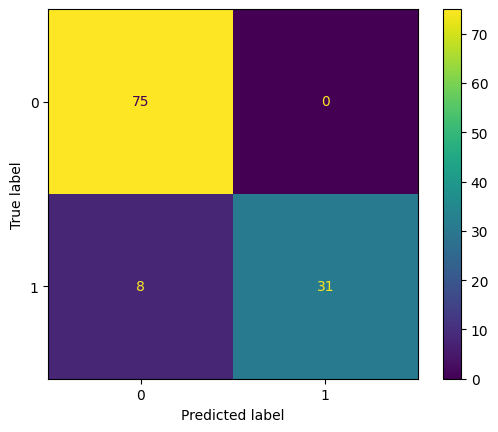

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
import numpy as np

def performance_measure(model):
  # predict probabilities for test set
  yhat_probs = model.predict(x_test_pca, verbose=0)
  # predict crisp classes for test set
  yhat_classes = np.argmax(yhat_probs,axis=1)

  # precision tp / (tp + fp)
  precision = precision_score(y_test, yhat_classes)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y_test, yhat_classes)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test, yhat_classes)
  print('F1 score: %f' % f1)
  #draw confusion matrix
  cm = confusion_matrix(y_test, yhat_classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

performance_measure(models[17])
# print(f'The evaluation of {clf} model')
# predictions = clf.predict(X_test)
# #Classification report
# print(classification_report(Y_test, predictions ,digits = 4))


---
بطور کلی مشاهده میشود که در بیشتر مدل های نا دقیق مشکل اصلی بایاس بودن مدل به یک کلاس است. یعنی تمام داده های تست را در یک کلاس طبقه بندی میکند. به همین دلیل ممکن است بتوان با تغییر در فرایند پیش پردازش داده ها و یا تغییر ساختار شبکه عصبی این بایاس بودن را کاهش داد تا به نتایج بهتری دست پیدا کرد.

جهت بررسی بیشتر تمام ماتریس های درهم ریختگی برای تمام مدل ها در زیر آمده است.

Optimizer: Adam 	learning rate: 0.001
Precision: 0.941176
Recall: 0.820513
F1 score: 0.876712


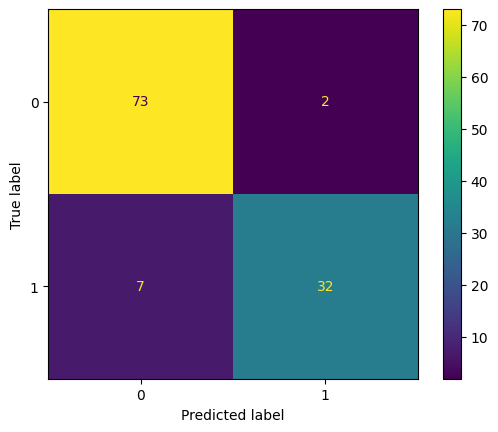

Optimizer: Adam 	learning rate: 0.001
Precision: 0.180328
Recall: 0.282051
F1 score: 0.220000


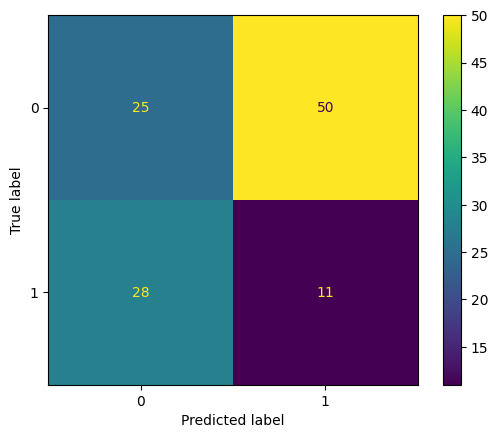

Optimizer: Adam 	learning rate: 0.001
Precision: 0.333333
Recall: 0.948718
F1 score: 0.493333


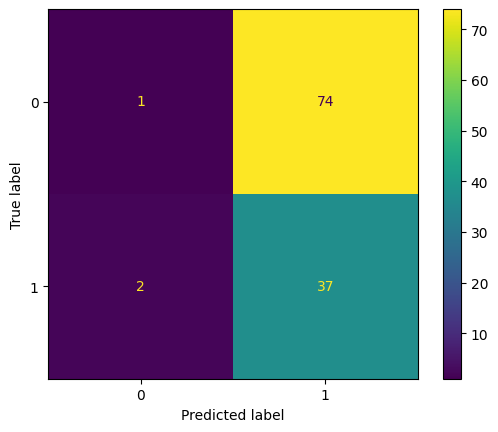

Optimizer: Adam 	learning rate: 0.001
Precision: 0.800000
Recall: 0.512821
F1 score: 0.625000


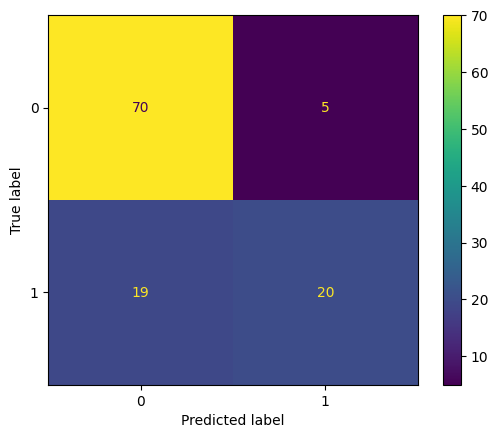

Optimizer: Adam 	learning rate: 0.001
Precision: 0.299065
Recall: 0.820513
F1 score: 0.438356


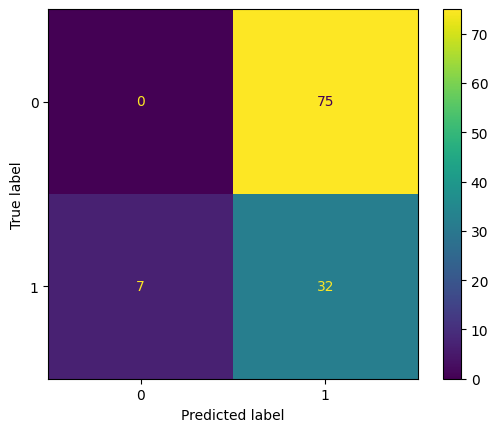

Optimizer: Adam 	learning rate: 0.001
Precision: 0.942857
Recall: 0.846154
F1 score: 0.891892


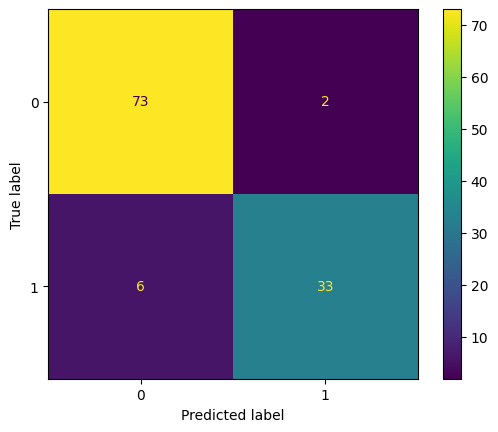

Optimizer: SGD 	learning rate: 0.01
Precision: 0.336283
Recall: 0.974359
F1 score: 0.500000


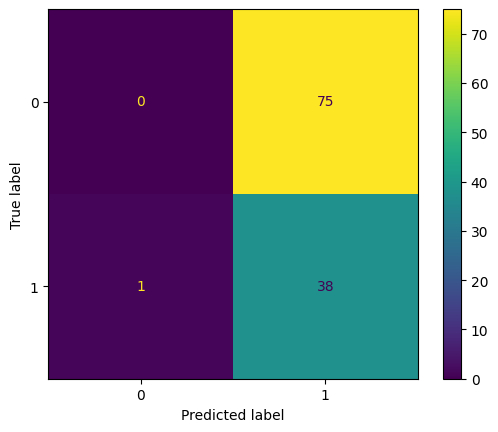

Optimizer: SGD 	learning rate: 0.01
Precision: 0.349515
Recall: 0.923077
F1 score: 0.507042


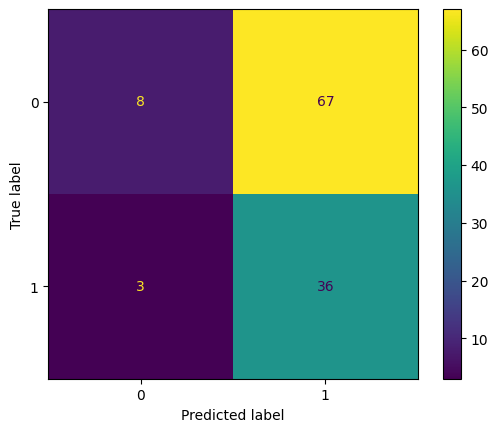

Optimizer: SGD 	learning rate: 0.01
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


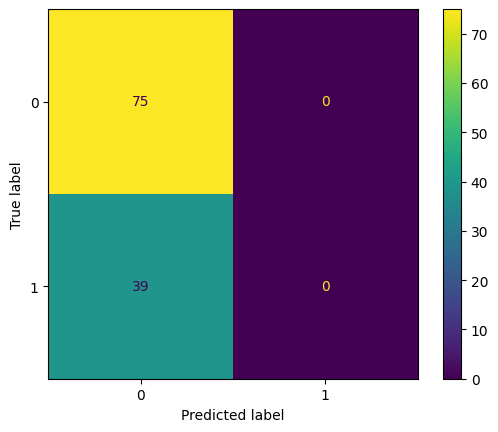

Optimizer: SGD 	learning rate: 0.01
Precision: 0.137255
Recall: 0.179487
F1 score: 0.155556


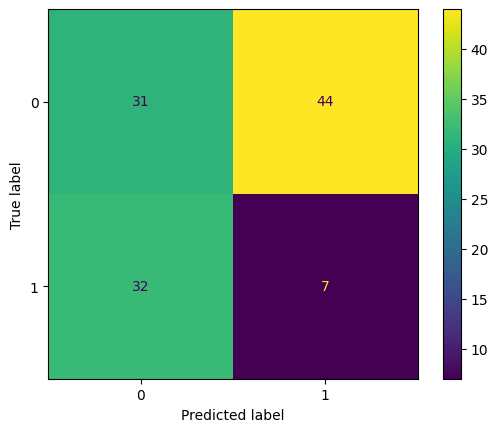

Optimizer: SGD 	learning rate: 0.01
Precision: 0.384615
Recall: 0.128205
F1 score: 0.192308


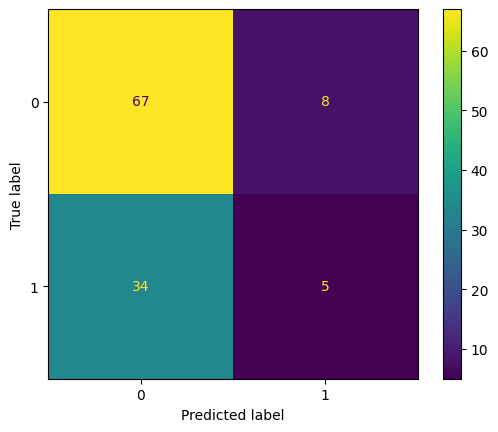

Optimizer: SGD 	learning rate: 0.01
Precision: 0.289855
Recall: 0.512821
F1 score: 0.370370


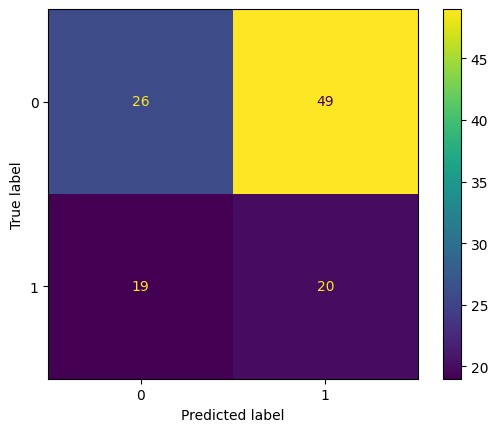

Optimizer: Adam 	learning rate: 0.1
Precision: 0.342105
Recall: 1.000000
F1 score: 0.509804


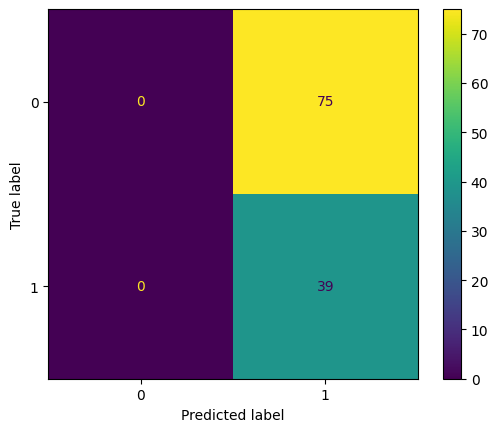

Optimizer: Adam 	learning rate: 0.1
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


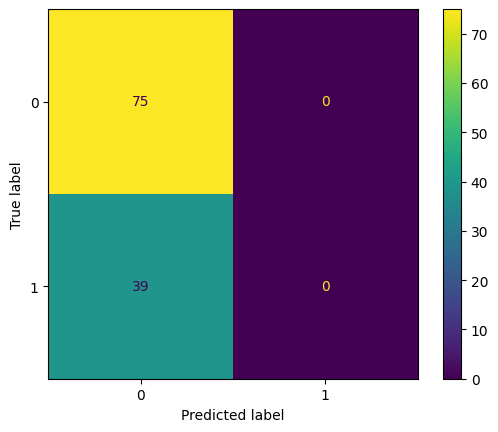

Optimizer: Adam 	learning rate: 0.1
Precision: 1.000000
Recall: 0.051282
F1 score: 0.097561


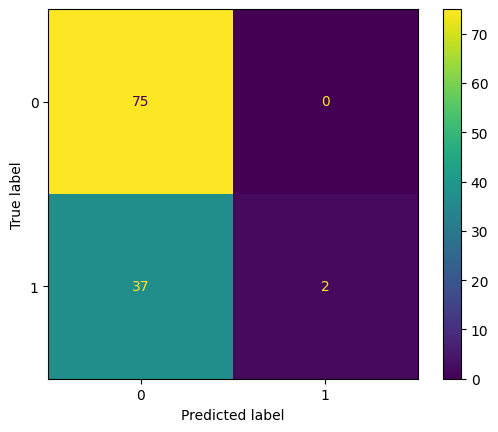

Optimizer: Adam 	learning rate: 0.001
Precision: 0.117647
Recall: 0.153846
F1 score: 0.133333


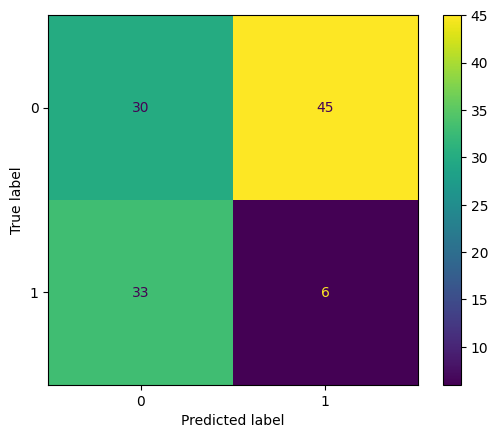

Optimizer: Adam 	learning rate: 0.001
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


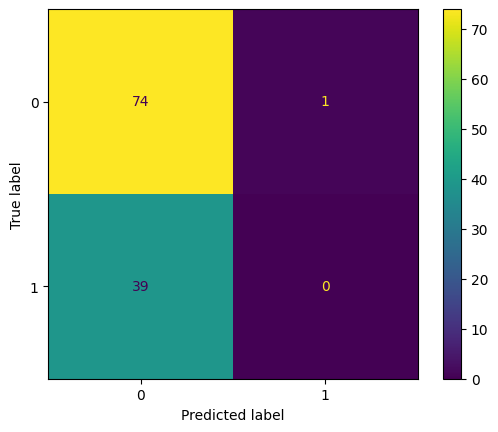

Optimizer: Adam 	learning rate: 0.001
Precision: 1.000000
Recall: 0.794872
F1 score: 0.885714


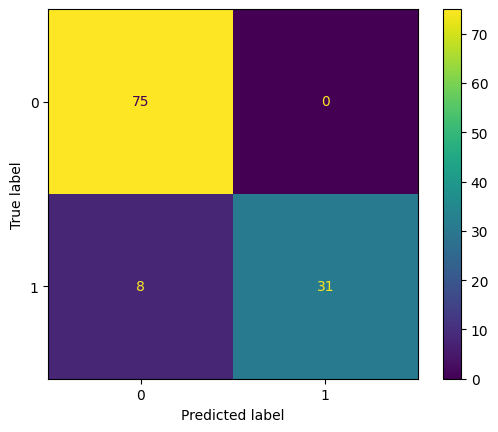

Optimizer: SGD 	learning rate: 0.1
Precision: 0.500000
Recall: 0.025641
F1 score: 0.048780


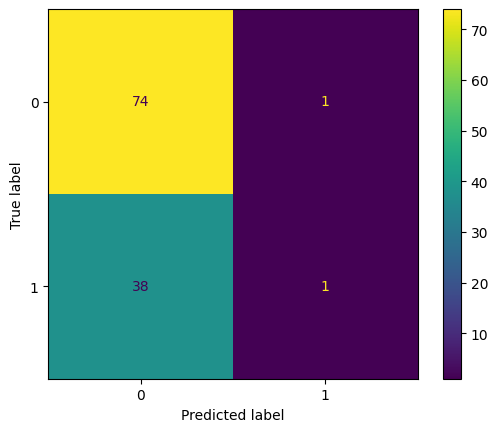

Optimizer: SGD 	learning rate: 0.001
Precision: 0.333333
Recall: 0.948718
F1 score: 0.493333


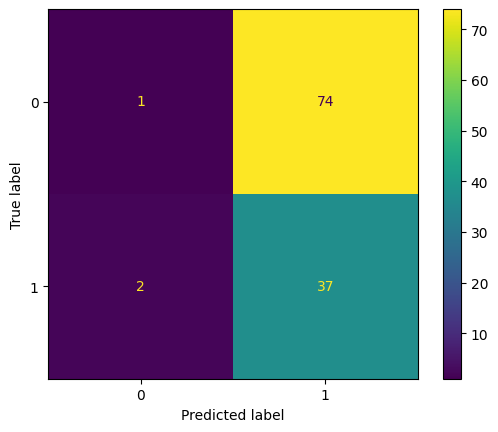

In [ ]:
for model in models:
  print('Optimizer:',model.optimizer.get_config()['name'],'\tlearning rate:',model.optimizer.get_config()['learning_rate'])
  performance_measure(model)